In [140]:
# Clone of repo
!git clone https://github.com/JustavGunker/02456-final-project.git

# Set directory
import os
os.chdir("/content/02456-final-project")


fatal: destination path '02456-final-project' already exists and is not an empty directory.


In [141]:
import os
import torch
import tifffile as tiff
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import numpy as np
import matplotlib.pyplot as plt


class ImageMaskDataset(Dataset):
    def __init__(self, image_dir, mask_dir, resize=(768, 768), augment = False):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.resize = resize
        self.augment = augment

        # List of image files
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.tif')])

        # Match masks by replacing 'image_v2_' with 'image_v2_mask_'
        mask_dir_files = os.listdir(mask_dir)
        self.mask_files = []
        for img_name in self.image_files:
            mask_name = img_name.replace('image_v2_', 'image_v2_mask_')
            if mask_name not in mask_dir_files:
                raise FileNotFoundError(f"Mask {mask_name} not found for image {img_name}")
            self.mask_files.append(mask_name)

        assert len(self.image_files) == len(self.mask_files), "Image and mask count mismatch!"

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        # Load TIFF images
        image = tiff.imread(img_path)
        mask = tiff.imread(mask_path)

        # If 3D stack, take middle slice
        if image.ndim == 3:
            image = image[image.shape[0] // 2]

        # Contrast stretch image to 0-1
        image = (image - image.min()) / (image.max() - image.min() + 1e-8)*255
        image = torch.from_numpy(image).float()

        # Convert mask to tensor
        mask = (mask - mask.min()) / (mask.max() - mask.min() + 1e-8)*255
        mask = ((mask < 4) | (mask == 118.005585) | (mask == 116.12109375) ).astype(np.float32)
        mask = torch.from_numpy(mask).float()

        # Add channel dimension to image if grayscale
        if image.ndim == 2:
            image = image.unsqueeze(0)  # C x H x W
        else:
            image = image.permute(2,0,1)  # HWC -> CHW

        # Resize image and mask
        image = F.interpolate(image.unsqueeze(0), size=self.resize, mode='bilinear', align_corners=False).squeeze(0)
        mask = F.interpolate(mask.unsqueeze(0).unsqueeze(0).float(), size=self.resize, mode='nearest').squeeze(0).float()

        # Augementation
        if self.augment:
            image, mask = random_augment(image, mask)

        return image, mask

# ---------------- Example Usage ----------------
# if __name__ == "__main__":
#
#    image_dir = "/archive/Original_images"
#    mask_dir  = "/archive/Original_masks"
#
#
#    dataset = ImageMaskDataset(image_dir, mask_dir, resize=(512, 512), augment = False)
#    dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0)
#    # full_dataset = ImageMaskDataset(image_dir, mask_dir, resize=(512, 512), augment=False)
#
#   # Test batch
#    images, masks = next(iter(dataloader))
#    print("Image batch shape:", images.shape)
#    print("Mask batch shape:", masks.shape)
#

In [166]:
USE_AUG = True   # set to False to disable data augmentation

# Paths
image_dir = "archive/Original_images"
mask_dir  = "archive/Original_masks"

# Base dataset (no augmentation)
# Used only to define length and splitting indices
base_dataset = ImageMaskDataset(image_dir, mask_dir, resize=(512, 512), augment=False)

# Optional: set a manual seed so splits are reproducible
g = torch.Generator()
g.manual_seed(42)

train_size = int(0.8 * len(base_dataset))
val_size   = int(0.1 * len(base_dataset))
test_size  = len(base_dataset) - train_size - val_size

# Split indices using random_split over a range of indices
train_subset, val_subset, test_subset = random_split(
    range(len(base_dataset)),
    [train_size, val_size, test_size],
    generator=g
)

train_indices = list(train_subset)
val_indices   = list(val_subset)
test_indices  = list(test_subset)

# Build datasets for each split
#    - Train: augment = USE_AUG
#    - Val/Test: augment = False (clean evaluation)
train_dataset = Subset(
    ImageMaskDataset(image_dir, mask_dir, resize=(512, 512), augment=USE_AUG),
    train_indices
)

val_dataset = Subset(
    ImageMaskDataset(image_dir, mask_dir, resize=(512, 512), augment=False),
    val_indices
)

test_dataset = Subset(
    ImageMaskDataset(image_dir, mask_dir, resize=(512, 512), augment=False),
    test_indices
)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=2, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=2, shuffle=False)

# Optional: quick sanity check
images, masks = next(iter(train_loader))
print(f"USE_AUG = {USE_AUG}")
print("Train batch image shape:", images.shape)
print("Train batch mask shape:", masks.shape)

USE_AUG = True
Train batch image shape: torch.Size([6, 1, 512, 512])
Train batch mask shape: torch.Size([6, 1, 512, 512])


In [167]:
print("Train uses augmentation:", USE_AUG)
print("Underlying train_dataset augment flag:", train_dataset.dataset.augment)


Train uses augmentation: True
Underlying train_dataset augment flag: True


In [143]:
import random

def random_augment(image, mask):
    """
    image: torch tensor, shape [C,H,W]
    mask:  torch tensor, shape [H,W] eller [1,H,W]
    return: augmented image, mask i samme format som input
    """

    # Ensure mask has channel dimension
    mask_was_2d = False
    if mask.ndim == 2:
        mask = mask.unsqueeze(0)   # [1,H,W]
        mask_was_2d = True

    # 1) Random horizontal flip
    if random.random() < 0.5:
        # dims: [C,H,W] → dim=2 is W
        image = torch.flip(image, dims=[2])
        mask  = torch.flip(mask,  dims=[2])

    # 2) Random vertical flip
    if random.random() < 0.5:
        # dims: [C,H,W] → dim=1 is H
        image = torch.flip(image, dims=[1])
        mask  = torch.flip(mask,  dims=[1])

    # 3) Random rotation (0, 90, 180, 270 degrees)
    k = random.choice([0, 1, 2, 3])  # 0=0°, 1=90°, 2=180°, 3=270°
    if k != 0:
        # Rotate over (H,W)-dimensions
        image = torch.rot90(image, k=k, dims=(1, 2))
        mask  = torch.rot90(mask,  k=k, dims=(1, 2))

    # 4) Random brightness & contrast (mild)
    if random.random() < 0.5:
        # brightness shift: +/- 20%
        brightness_factor = 1.0 + 0.2 * (random.random() - 0.5)
        # contrast shift: +/- 20%
        contrast_factor   = 1.0 + 0.2 * (random.random() - 0.5)

        image = image * contrast_factor + brightness_factor * 10.0
        image = torch.clamp(image, 0, 255)

    # 5) Random Gaussian noise
    if random.random() < 0.5:
        noise_std = 0.03 * torch.std(image)
        noise = torch.randn_like(image) * noise_std
        image = torch.clamp(image + noise, 0, 255)


    # Remove channel-dim again if it was 2D to start with
    if mask_was_2d:
        mask = mask.squeeze(0)

    return image, mask


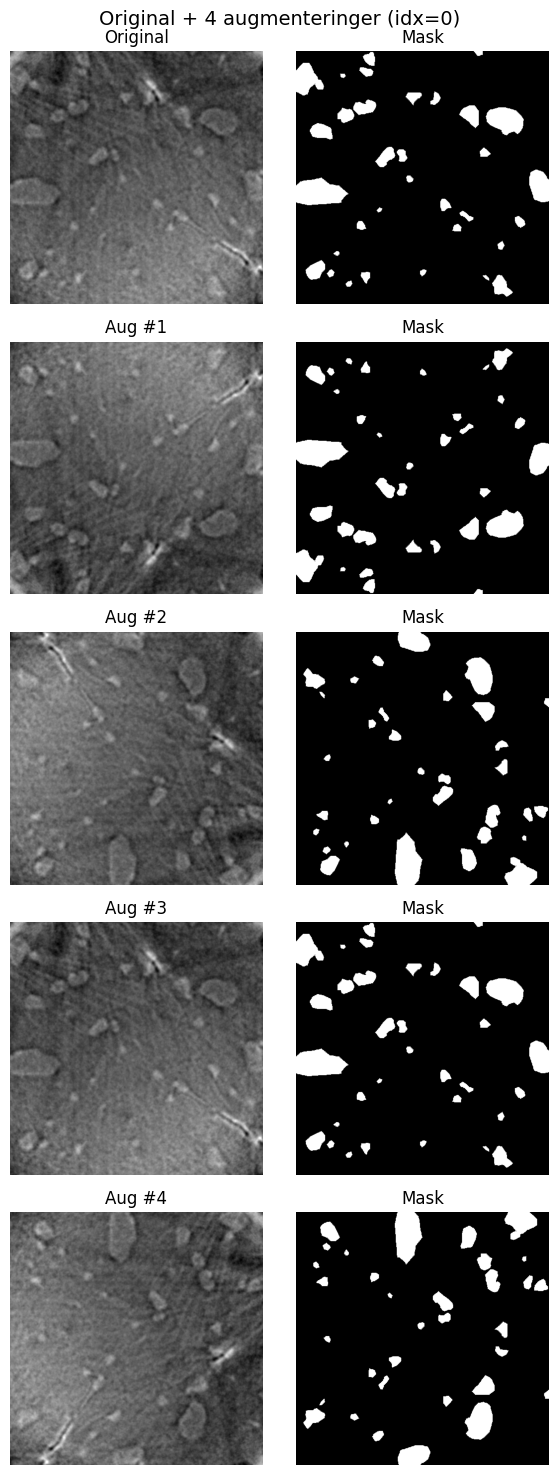

In [144]:
# Data augmentation display


def show_image_and_mask(img, msk, ax_img, ax_msk, title=""):
    # img: [C,H,W], msk: [H,W] eller [1,H,W]
    img_np = img.squeeze(0).cpu().numpy()
    msk_np = msk.squeeze().cpu().numpy()

    ax_img.imshow(img_np, cmap="gray")
    ax_img.set_title(title)
    ax_img.axis("off")

    ax_msk.imshow(msk_np, cmap="gray")
    ax_msk.set_title("Mask")
    ax_msk.axis("off")

# Vælg en vilkårlig sample (eller sæt idx=0,1,... selv)
idx = 0
img, msk = dataset[idx]

# Hvor mange augmenteringer vil du se?
n_aug = 4

fig, axes = plt.subplots(n_aug + 1, 2, figsize=(6, 3*(n_aug+1)))
fig.suptitle(f"Original + {n_aug} augmenteringer (idx={idx})", fontsize=14)

# Første række: original
show_image_and_mask(img, msk, axes[0,0], axes[0,1], title="Original")

# De næste rækker: forskellige augmenteringer
for i in range(1, n_aug+1):
    img_aug, msk_aug = random_augment(img.clone(), msk.clone())
    show_image_and_mask(img_aug, msk_aug, axes[i,0], axes[i,1], title=f"Aug #{i}")

plt.tight_layout()
plt.show()


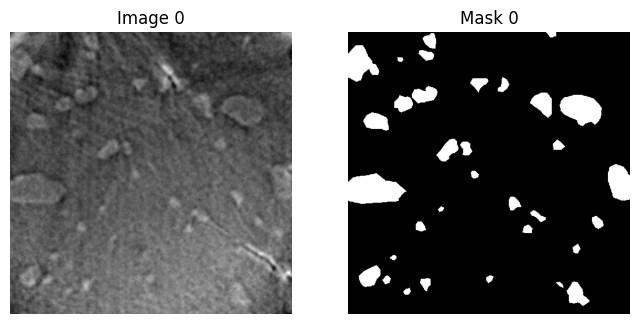

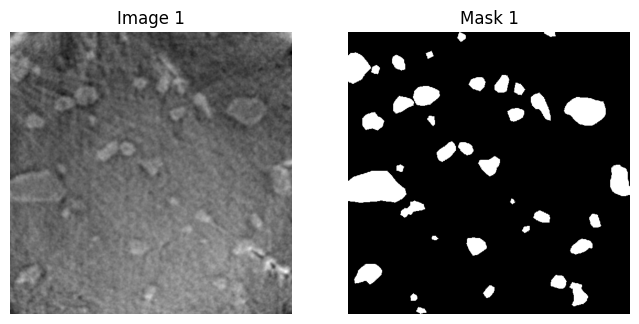

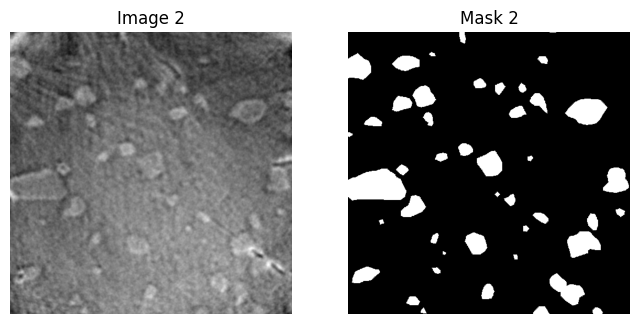

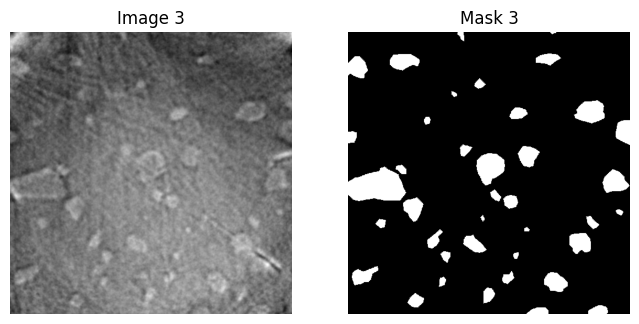

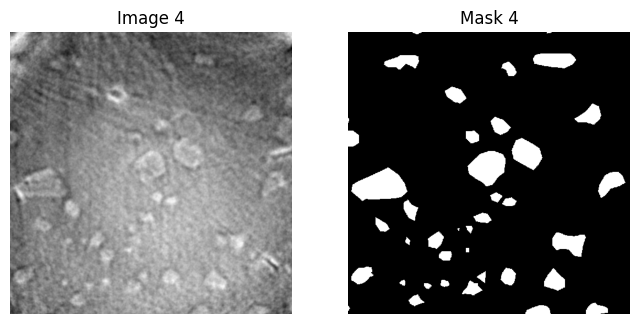

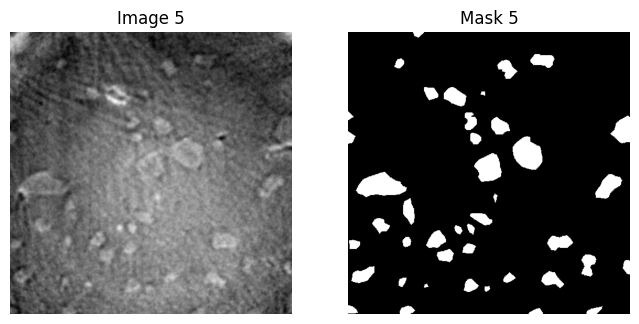

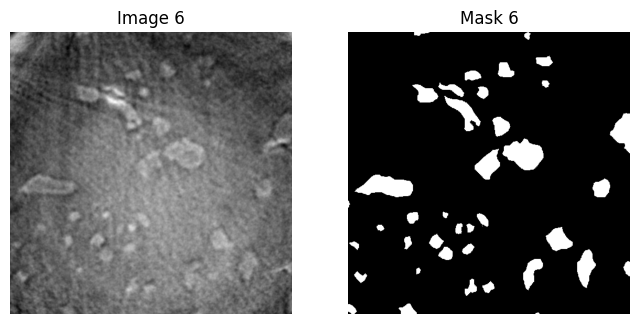

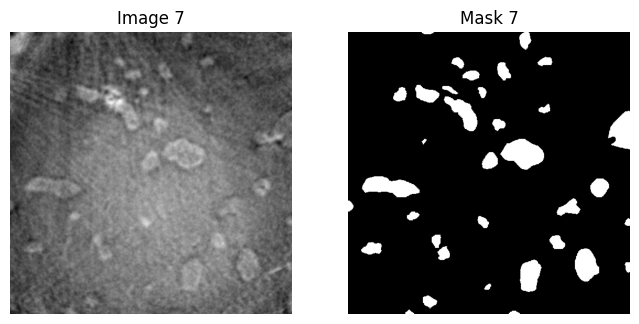

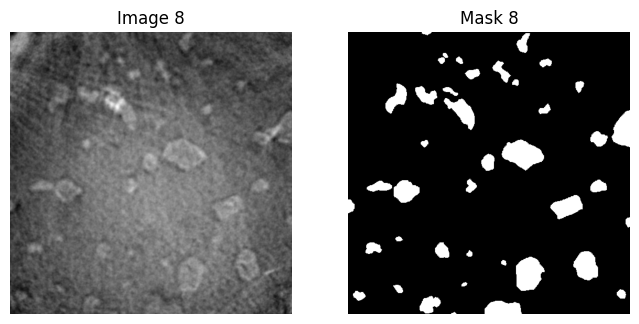

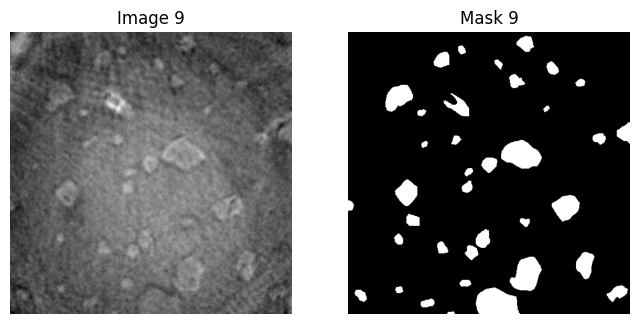

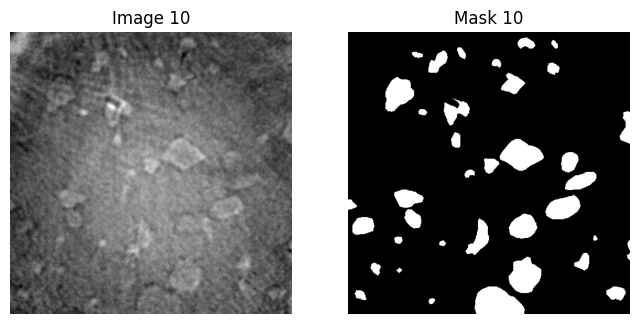

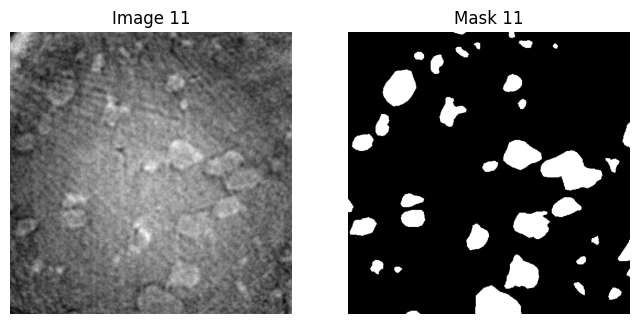

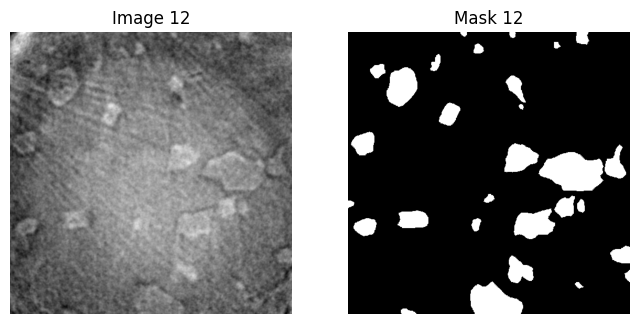

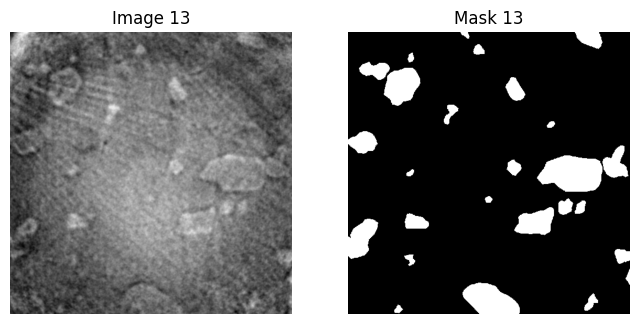

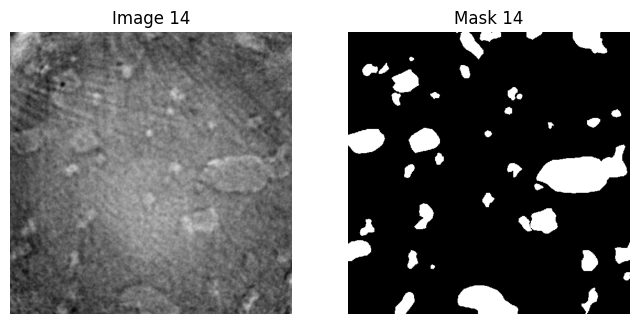

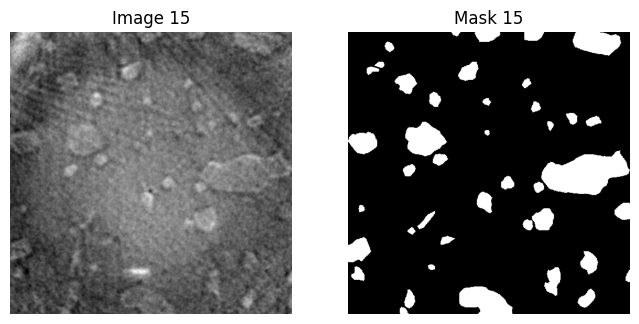

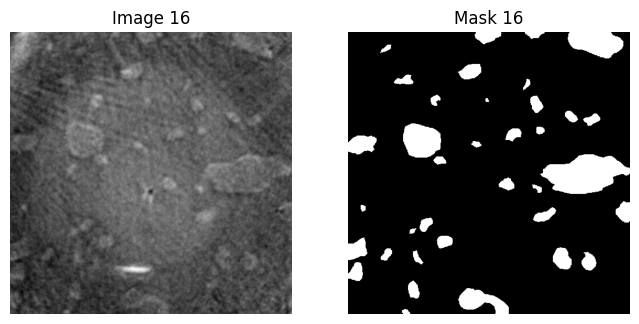

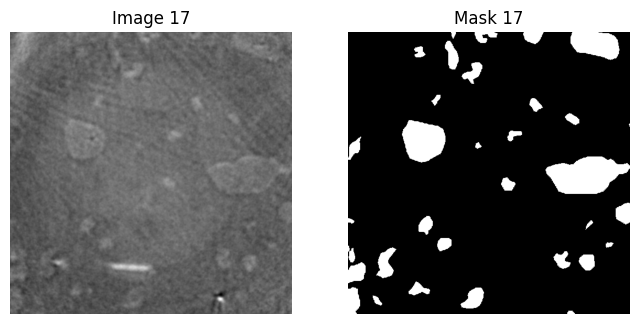

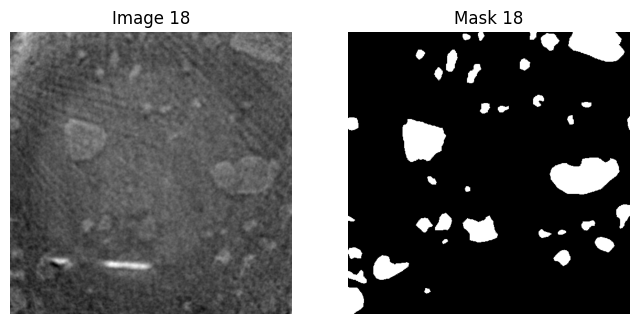

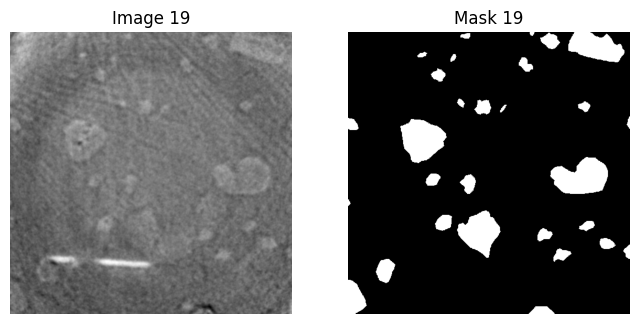

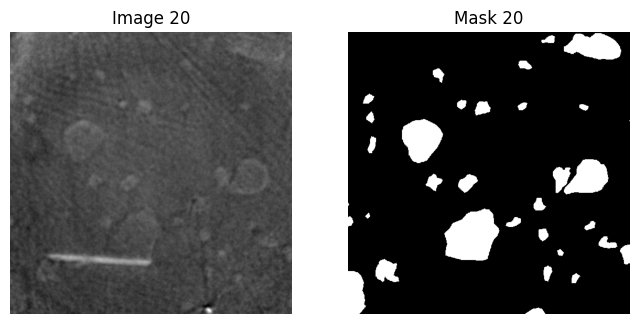

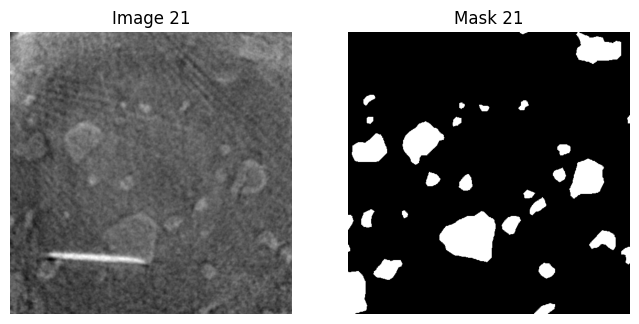

In [145]:
# plot of all OG images and masks

for idx in range(len(dataset)):
    # Get image and mask
    img, mask = dataset[idx]  # assuming dataset returns (image, mask)

    # Convert tensors to numpy
    img_np = img.permute(1,2,0).numpy() if img.ndim == 3 else img.numpy()
    mask_np = mask.squeeze().numpy()  # 1xHxW -> HxW

    # Normalize mask for visualization
    mask_vis = (mask_np - mask_np.min()) / (mask_np.max() - mask_np.min() + 1e-8)


    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(img_np, cmap='gray')
    plt.title(f"Image {idx}")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(mask_vis, cmap='gray')
    plt.title(f"Mask {idx}")
    plt.axis("off")

    plt.show()


In [146]:
from collections import Counter

pixel_counter = Counter()

for i in range(len(dataset)):
    _, mask = dataset[i]
    mask_np = mask.numpy().squeeze()

    # Flatten and filter pixels > 50
    pixels_gt_50 = mask_np[mask_np > 50].flatten().tolist()

    # Update counter
    pixel_counter.update(pixels_gt_50)

# Get most common values
most_common = pixel_counter.most_common(3)

print("Most frequent pixel values > 50:")
for val, cnt in most_common:
    print(f"value={val} → count={cnt}")


Most frequent pixel values > 50:


In [147]:
import torch.nn as nn
import torch.optim as optim
import numpy as np

def double_conv(in_channels, out_channels):

    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

class unet(nn.Module):
    def __init__(self, in_channels=1, num_classes=1):
        super(unet, self).__init__()

        self.conv_down1 = double_conv(in_channels, 16)
        self.conv_down2 = double_conv(16, 32)
        self.conv_down3 = double_conv(32, 64)
        self.conv_down4 = double_conv(64, 128)
        self.conv_down5 = double_conv(128, 256)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up4 = double_conv(128 + 256, 128)
        self.conv_up3 = double_conv(64 + 128, 64)
        self.conv_up2 = double_conv(32 + 64, 32)
        self.conv_up1 = double_conv(32 + 16, 16)

        self.last_conv = nn.Conv2d(16, num_classes, kernel_size=1)

    def forward(self, x):
        conv1 = self.conv_down1(x)
        x = self.maxpool(conv1)
        conv2 = self.conv_down2(x)
        x = self.maxpool(conv2)
        conv3 = self.conv_down3(x)
        x = self.maxpool(conv3)
        conv4 = self.conv_down4(x)
        x = self.maxpool(conv4)
        x = self.conv_down5(x)
        x = self.upsample(x)


        x = torch.cat([x, conv4], dim=1)
        x = self.conv_up4(x)
        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.conv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.conv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.conv_up1(x)

        out = self.last_conv(x)

        return out




In [148]:
def train(model, train_loader, val_loader, optimizer, criterion, device, num_epochs):
    history = {k: [] for k in ["train_loss","val_loss","val_dice","val_iou","val_acc","val_sens","val_spec", "Epoch"]}

    # Register best loss and epoch
    best_loss = float("inf")
    best_epoch = -1

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        num_batches = len(train_loader)
        for batch_idx, (images, masks) in enumerate(train_loader):
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, masks)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        dice_scores, iou_scores, acc_scores, sens_scores, spec_scores = [], [], [], [], []
        eps = 1e-7
        num_val_batches = len(val_loader)
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)

                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

                probs = torch.sigmoid(outputs)
                preds = (probs >= 0.5).float()
                targets = masks.float()

                intersection = (preds * targets).sum(dim=(1,2,3))
                pred_sum = preds.sum(dim=(1,2,3))
                mask_sum = targets.sum(dim=(1,2,3))
                union = ((preds + targets) > 0).float().sum(dim=(1,2,3))

                dice = (2*intersection + eps) / (pred_sum + mask_sum + eps)
                iou  = (intersection + eps) / (union + eps)

                tp = intersection
                tn = ((1 - preds) * (1 - targets)).sum(dim=(1,2,3))
                fp = (preds * (1 - targets)).sum(dim=(1,2,3))
                fn = ((1 - preds) * targets).sum(dim=(1,2,3))

                acc  = (tp + tn + eps) / (tp + tn + fp + fn + eps)
                sens = (tp + eps) / (tp + fn + eps)
                spec = (tn + eps) / (tn + fp + eps)

                dice_scores.append(dice.mean().item())
                iou_scores.append(iou.mean().item())
                acc_scores.append(acc.mean().item())
                sens_scores.append(sens.mean().item())
                spec_scores.append(spec.mean().item())

        avg_train_loss = train_loss / num_batches
        avg_val_loss = val_loss / num_val_batches
        val_dice = float(np.mean(dice_scores))
        val_iou = float(np.mean(iou_scores))
        val_acc = float(np.mean(acc_scores))
        val_sens = float(np.mean(sens_scores))
        val_spec = float(np.mean(spec_scores))

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["val_dice"].append(val_dice)
        history["val_iou"].append(val_iou)
        history["val_acc"].append(val_acc)
        history["val_sens"].append(val_sens)
        history["val_spec"].append(val_spec)
        history["Epoch"].append(epoch)

        # Model stays on best validation loss
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            best_epoch = epoch
            torch.save(model.state_dict(), "best_model.pth")

        if epoch % 10 == 0:
          print(f"Epoch {epoch:03d}/{num_epochs} | "
                f"train_loss={avg_train_loss:.4f} | val_loss={avg_val_loss:.4f} | "
                f"Dice={val_dice:.4f} | IoU={val_iou:.4f} | "
                f"Acc={val_acc:.4f} | Sens={val_sens:.4f} | Spec={val_spec:.4f}")

    print(f"Best val_loss {best_loss:.4f} at epoch {best_epoch}")
    return history


In [168]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = unet().to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
num_epochs = 10

history = train(model, train_loader, val_loader, optimizer, criterion, device, num_epochs)


Epoch 000/10 | train_loss=0.7236 | val_loss=0.7729 | Dice=0.2023 | IoU=0.1129 | Acc=0.1129 | Sens=1.0000 | Spec=0.0000
Best val_loss 0.6036 at epoch 9


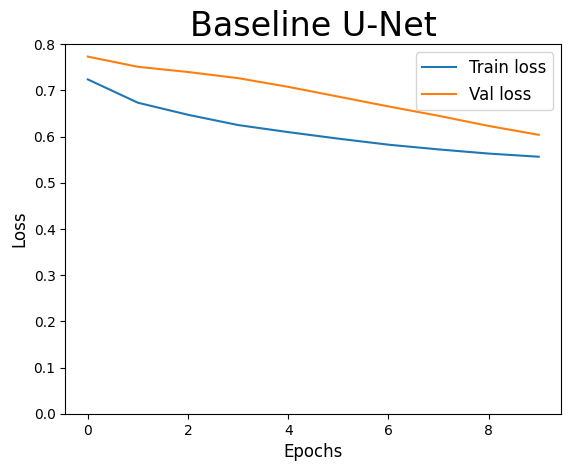

In [169]:
title = "Baseline U-Net"
if USE_AUG:
  titel = "Baseline U-Net with augmentation"

plt.plot(history['Epoch'], history['train_loss'], label='Train loss')
plt.plot(history['Epoch'], history['val_loss'], label='Val loss')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.ylim(0, 0.8)
plt.title(title, fontsize=24)
plt.legend(fontsize=12)



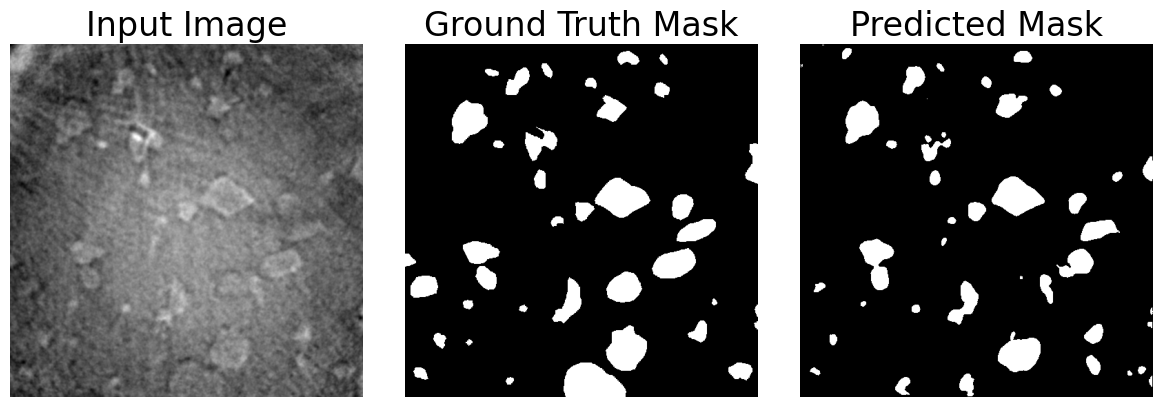

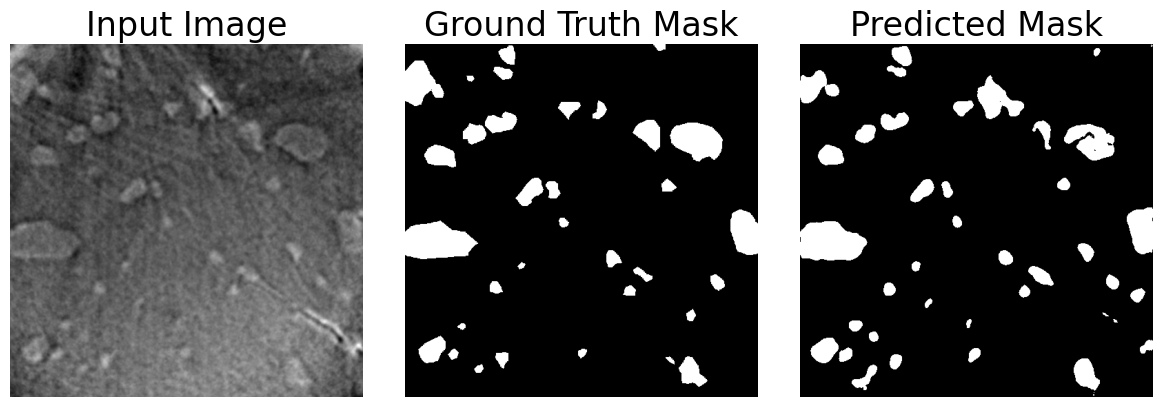

In [151]:
import matplotlib.pyplot as plt
model.eval()  # make sure the model is in eval mode

# Take one batch from the test loader
images, masks = next(iter(test_loader))  # images: [B,C,H,W], masks: [B,1,H,W]

for i in range(images.size(0)):
    image = images[i].to(device).unsqueeze(0)  # add batch dim
    mask = masks[i].to(device)

    with torch.no_grad():
        output = model(image)                  # [1,1,H,W]
        probs = torch.sigmoid(output)          # probabilities
        pred_mask = (probs > 0.5).float()     # binary mask

    # Move to CPU for plotting
    image_cpu = image.squeeze(0).cpu()
    mask_cpu = mask.cpu()
    pred_cpu = pred_mask.squeeze(0).cpu()

    # Plot
    fig, axs = plt.subplots(1,3, figsize=(12,4))
    axs[0].imshow(image_cpu.squeeze(0), cmap='gray')
    axs[0].set_title("Input Image", fontsize=24)
    axs[0].axis('off')

    axs[1].imshow(mask_cpu.squeeze(0), cmap='gray')
    axs[1].set_title("Ground Truth Mask", fontsize=24)
    axs[1].axis('off')

    axs[2].imshow(pred_cpu.squeeze(0), cmap='gray')
    axs[2].set_title("Predicted Mask", fontsize=24)
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()

Best epoch: 49
  val_loss = 0.3318
  Dice     = 0.7881
  IoU      = 0.6506


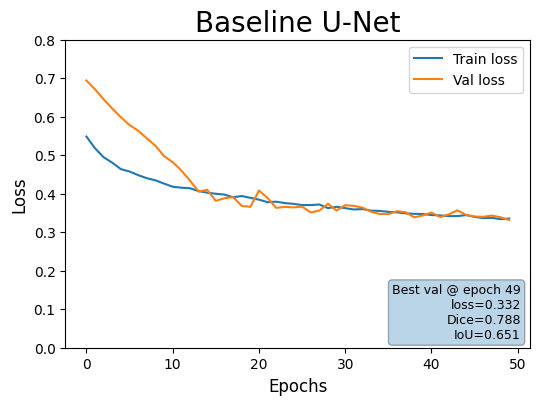

In [152]:
# Plot of train-val-loss and metrics

epochs   = np.array(history["Epoch"])
val_loss = np.array(history["val_loss"])
val_dice = np.array(history["val_dice"])
val_iou  = np.array(history["val_iou"])

# vælg bedste epoch efter laveste val_loss (kan også være højeste val_dice)
best_idx   = val_loss.argmin()
best_epoch = epochs[best_idx]

best_val_loss = val_loss[best_idx]
best_val_dice = val_dice[best_idx]
best_val_iou  = val_iou[best_idx]

print(f"Best epoch: {best_epoch}")
print(f"  val_loss = {best_val_loss:.4f}")
print(f"  Dice     = {best_val_dice:.4f}")
print(f"  IoU      = {best_val_iou:.4f}")

# dit plot
title = "Baseline U-Net with augmentation" if dataset.augment else "Baseline U-Net"
plt.figure(figsize=(6,4))
plt.plot(history['Epoch'], history['train_loss'], label='Train loss')
plt.plot(history['Epoch'], history['val_loss'], label='Val loss')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.ylim(0, 0.8)
plt.title(title, fontsize=20)
plt.legend(fontsize=10)

# tekstboks med key metrics i hjørnet
text = (f"Best val @ epoch {best_epoch}\n"
        f"loss={best_val_loss:.3f}\n"
        f"Dice={best_val_dice:.3f}\n"
        f"IoU={best_val_iou:.3f}")
plt.text(0.98, 0.02, text,
         transform=plt.gca().transAxes,
         ha="right", va="bottom",
         fontsize=9,
         bbox=dict(boxstyle="round", alpha=0.3))

plt.show()
